In [1]:
import patchseq_utils.analysis as utils
from patchseq_utils import dprime, pipelines as pipe, cluster_pairs as cp
import sklearn.model_selection as ms
from sklearn.naive_bayes import GaussianNB

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.patches import Rectangle
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [3]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import plot_confusion_matrix

In [5]:
human_df = human_df.loc[pd.read_csv(projectdir/"human_l1_dataset_strict.csv", index_col=0).index]

## ZINB run

In [25]:
import h5py
f = h5py.File("/home/tom.chartrand/projects/human_l1/zinb_human.h5", "r")
spaced_log_mu = f['regularizations/spaced_log_mu'][...]
fit_phi = f['regularizations/phi_kr_fit'][...]
fit_pi = f['regularizations/pi_sig_fit'][...]
f.close()

In [8]:
# shiny_df = get_full_human_metadata_df()
# np.savetxt('/home/tom.chartrand/projects/human_l1/human_inh_ps_ids.txt', shiny_df['sample_id'].values, fmt="%s")

In [226]:
shiny_df = get_full_mouse_metadata_df()
np.savetxt('/home/tom.chartrand/projects/human_l1/mouse_inh_ps_ids.txt', shiny_df['sample_id'].values, fmt="%s")

In [147]:
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
shiny_df = shiny._load_shiny_data(directory=shiny_dir)
shiny_df = shiny_df[shiny_df['cell_subclass'].isin(['VIP', 'LAMP5/PAX6/Other'])]
# len(shiny_df)
np.savetxt('/home/tom.chartrand/projects/human_l1/human_inh_facs_ids.txt', shiny_df['sample_id'].values, fmt="%s")

## NB confusion matrix comparison

CV accuracy: 0.61+/-0.07


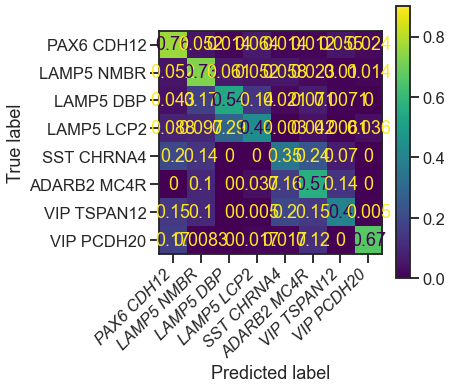

In [14]:
clf = GaussianNB()
# X0 = data[features].values
# X = pipe.preproc_pipeline().fit_transform(X0)
# types = data[cluster].astype('category')
# pipe.plot_cm(clf, X, types, include_values=False)
pipe.plot_cm(clf, data, features, cluster)

## ephys dprime

In [17]:
# ephys_data, clusters = subset_data(human_df, ephys_features, ephys_frac_min=0, cluster_min=10)
ephys_data = subset_data(human_df.query("collaborator=='AIBS' & failed_fx_long_squares==False"), 
                                ephys_features, ephys_frac_min=0, cluster_min=9)
complete_features = subset_features(ephys_data, ephys_features, complete_frac=0.8)
features = complete_features
# features = [x for x in complete_features if x != 'fast_trough_v_adapt_ratio']

In [18]:
set(ephys_features).difference(complete_features)

{'3db_freq_chirp',
 'adp_v_last_rheo',
 'first_isi_inv_rheo',
 'low_freq_impedance_chirp',
 'mean_isi_rheo',
 'peak_freq_chirp',
 'peak_impedance_chirp',
 'peak_ratio_chirp',
 'phase_low_chirp',
 'phase_peak_chirp',
 'sag_tau_depol',
 'sync_freq_chirp',
 'total_inductive_phase_chirp'}

In [19]:
data = ephys_data.pipe(remove_unused_categories)
clusters = data[cluster].cat.categories
data[cluster].value_counts(dropna=False)

LAMP5 NMBR     66
PAX6 CDH12     31
ADARB2 MC4R    24
NaN            16
VIP TSPAN12    15
LAMP5 LCP2     12
LAMP5 DBP      12
SST CHRNA4      9
VIP PCDH20      9
Name: t-type, dtype: int64

### Gaussian mixture

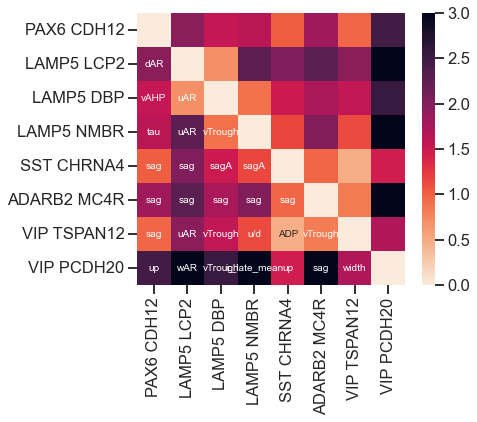

In [18]:
clf = GaussianNB()
ephys_dprime, records = cp.pairwise_cluster_distances(clf, data, features, cluster, details=True)
plot_dprime_features(ephys_dprime, records)

In [23]:
df = pd.DataFrame.from_records(records, index=['cluster_1', 'cluster_2'])
df['short_feat'] = df['feature'].map(short_feat)

pairwise_features = df.feature.unique()
pairwise_features

array(['downstroke_adapt_ratio', 'fast_trough_deltav_hero',
       'upstroke_adapt_ratio', 'tau', 'trough_slowdeltav_rheo', 'sag',
       'sag_area', 'upstroke_downstroke_ratio_ramp', 'postap_slope_ramp',
       'upstroke_short_square', 'width_adapt_ratio', 'ir_late_mean',
       'upstroke_rheo', 'width_hero'], dtype=object)

In [24]:
df.short_feat.unique()

array(['dAR', 'vAHP', 'uAR', 'tau', 'vTrough', 'sag', 'sagA', 'u/d',
       'ADP', 'up', 'wAR', 'IR', 'width'], dtype=object)

### dprime hierarchical clustering

In [107]:
plot_dprime_tree(clf, data, features, cluster, method='average')

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
plot_dprime_tree(clf, data, features, cluster, method='complete')

TypeError: '(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       4, 4, 4, 5, 5, 6]), array([1, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 3, 4, 5, 6, 7, 4, 5, 6, 7,
       5, 6, 7, 6, 7, 7]))' is an invalid key

In [104]:
plot_dprime_tree(clf, data, features, cluster, method='weighted')

ValueError: The condensed distance matrix must contain only finite values.

### One vs All dprime

In [113]:
reload(cluster_pairs)

<module 'cluster_pairs' from '/allen/programs/celltypes/workgroups/humancelltypes/tom/projects/ephys_analysis/cluster_pairs.py'>

In [54]:
clf = GaussianNB()
dist, records = cp.ova_cluster_distances(clf, data, features, cluster, n_feat=4)
df = pd.DataFrame.from_records(records, index='cluster')

<AxesSubplot:>

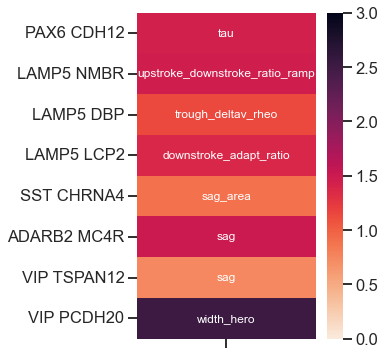

In [55]:
# overall dprime
fig, ax = plt.subplots(figsize=(4,6))
annot=df.loc[df['rank']==0, ['feature']]
sns.heatmap(dist[:,None], yticklabels=clusters, xticklabels=[''], annot=annot, fmt='s', cmap='rocket_r',
            annot_kws=dict(size=12), vmin=0, vmax=3,
           cbar=True, ax=ax)

<AxesSubplot:xlabel='rank'>

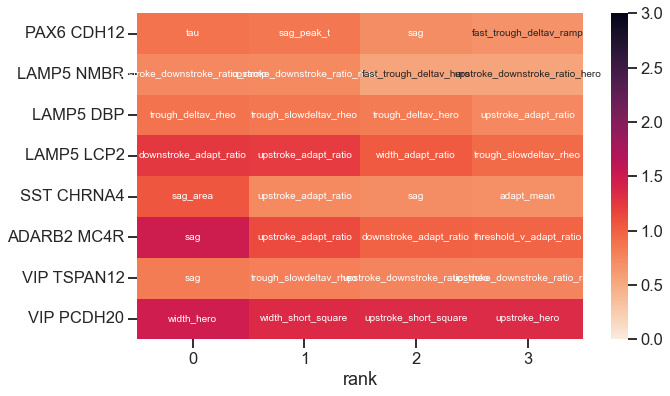

In [58]:
# Not cross-validated!
df2 = df.reset_index().pivot(index='cluster', columns='rank', values=['dprime','feature']).loc[clusters]

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df2['dprime'].astype('float'), cmap='rocket_r',  annot=df2['feature'], fmt='s', 
            annot_kws=dict(size=10),  cbar=True, ax=ax, vmin=0, vmax=3,)

In [35]:
reload(cluster_pairs)

<module 'cluster_pairs' from '/allen/programs/celltypes/workgroups/humancelltypes/tom/projects/ephys_analysis/cluster_pairs.py'>

In [36]:
# compare feature dprimes
# only showing top features, rest blanked out
dist, records = cluster_pairs.ova_cluster_distances(clf, data, features, cluster, n_feat=30)
df = pd.DataFrame.from_records(records, index='cluster')
df.reset_index().pivot(index='feature', columns='cluster', values=['dprime'])

dprime                                  \
cluster                        ADARB2 MC4R LAMP5 DBP LAMP5 LCP2 LAMP5 NMBR   
feature                                                                      
adapt_hero                        0.397631       NaN        NaN   0.296611   
adapt_max                              NaN       NaN   0.443643        NaN   
adapt_mean                             NaN       NaN   0.343236        NaN   
ahp_delay_ratio_5spike                 NaN       NaN   0.467275        NaN   
ahp_delay_ratio_hero                   NaN       NaN   0.811738        NaN   
...                                    ...       ...        ...        ...   
width_short_square                     NaN  0.452110        NaN        NaN   
width_suprathresh_hero                 NaN  0.481109   0.340392        NaN   
width_suprathresh_ramp                 NaN       NaN   0.473983        NaN   
width_suprathresh_rheo                 NaN  0.408845   0.513790        NaN   
width_suprathresh_short_square         NaN  0.487397        NaN        NaN   

                                                                             
cluster                        PAX6 CDH12 SST CHRNA4 VIP PCDH20 VIP TSPAN12  
feature                                                                      
adapt_hero                            NaN   0.391798   0.521715         NaN  
adapt_max                             NaN   0.676287   0.612640         NaN  
adapt_mean                            NaN   0.694448   0.775921         NaN  
ahp_delay_ratio_5spike           0.391439   0.385464   0.637688    0.473956  
ahp_delay_ratio_hero                  NaN        NaN   0.492574    0.679949  
...                                   ...        ...        ...         ...  
width_short_square                    NaN        NaN   1.357133    0.471156  
width_suprathresh_hero                NaN        NaN   1.300189    0.607790  
width_suprathresh_ramp                NaN        NaN   0.699334    0.454102  
width_suprathresh_rheo                NaN        NaN   0.955672    0.495557  
width_suprathresh_short_square        NaN        NaN   1.186781    0.437479  

[77 rows x 8 columns]

### metric / method variations

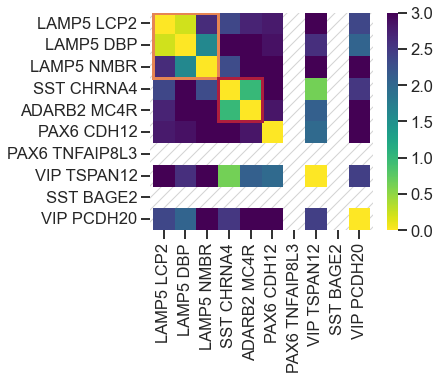

In [39]:
clf = LogisticRegression(class_weight='balanced')
ephys_dprime_log, records = cp.pairwise_cluster_distances(clf, ephys_data, complete_features, cluster, details=False)

plt.figure(figsize=(5,4))
# df1 = cp.plot_dprime(clf, ephys_data, complete_features, cluster);
cp.plot_dprime(clf, ephys_data, complete_features, cluster_list=l1_types_human)
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))

In [13]:
reload(cp)

<module 'patchseq_utils.cluster_pairs' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/cluster_pairs.py'>

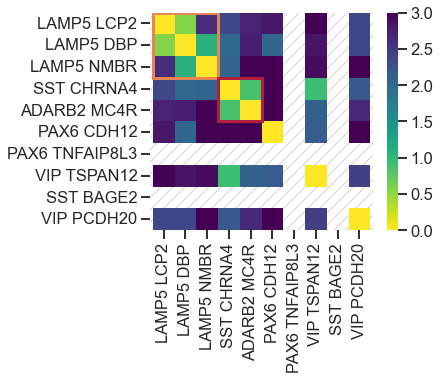

In [20]:
fig, ax = plt.subplots(figsize=(5,4))
clf = RandomForestClassifier(class_weight='balanced_subsample')
cp.plot_dprime(clf, ephys_data, complete_features, cluster_list=l1_types_human)
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))

# ephys_dprime_rf, records = cp.pairwise_cluster_distances(clf, ephys_data, complete_features, cluster, details=False)
# ephys_dprime_rf = ephys_dprime_rf.reindex(index=l1_types_human, columns=l1_types_human)

In [36]:
ephys_dprime_rf, records = cp.pairwise_cluster_distances(clf, ephys_data, complete_features, cluster, details=False)

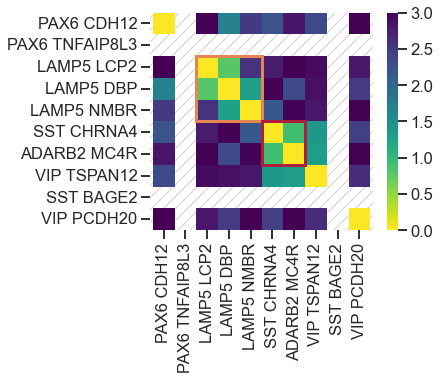

In [273]:
fig, ax = plt.subplots(figsize=(5,4))
# df1 = cp.plot_dprime(clf, ephys_data, complete_features, cluster);
# ax.add_patch(Rectangle((0, 0), 5, 5, fill=False, hatch='xx'))
g = sns.heatmap(ephys_dprime_rf, cmap='viridis_r', vmin=0, vmax=3, cbar=True, ax=ax)
# g.set_facecolor('xkcd:salmon')
ax.patch.set_edgecolor('lightgrey')
ax.patch.set_hatch('//')
plt.axis('equal')
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((2,2), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((5,5), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
plt.show()

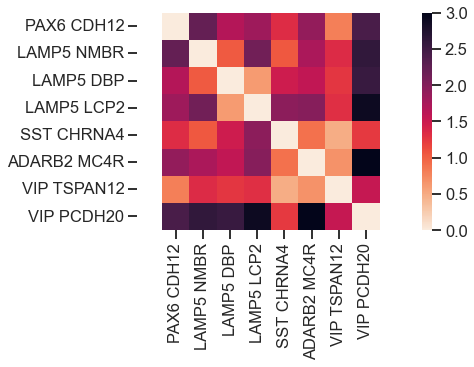

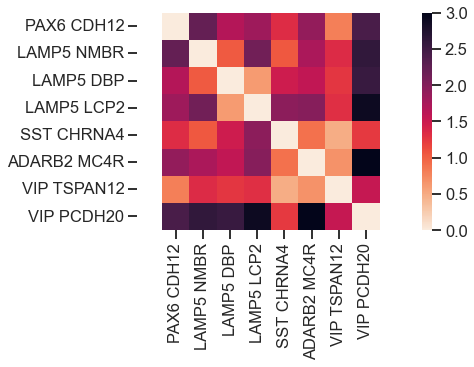

PAX6 CDH12  LAMP5 NMBR  LAMP5 DBP    LAMP5 LCP2  SST CHRNA4  \
PAX6 CDH12     0.000000    0.000000   0.006061  0.000000e+00         0.0   
LAMP5 NMBR     0.000000    0.000000   0.002147  0.000000e+00         0.0   
LAMP5 DBP      0.006061    0.002147   0.000000  0.000000e+00         0.0   
LAMP5 LCP2     0.000000    0.000000   0.000000  0.000000e+00         0.0   
SST CHRNA4     0.000000    0.000000   0.000000  0.000000e+00         0.0   
ADARB2 MC4R    0.000000    0.000000   0.000000  0.000000e+00         0.0   
VIP TSPAN12    0.000000    0.000000   0.000000  0.000000e+00         0.0   
VIP PCDH20     0.000000    0.000000   0.000000 -3.108624e-15         0.0   

             ADARB2 MC4R  VIP TSPAN12    VIP PCDH20  
PAX6 CDH12           0.0          0.0  0.000000e+00  
LAMP5 NMBR           0.0          0.0  0.000000e+00  
LAMP5 DBP            0.0          0.0  0.000000e+00  
LAMP5 LCP2           0.0          0.0 -3.108624e-15  
SST CHRNA4           0.0          0.0  0.000000e+00  
ADARB2 MC4R          0.0          0.0  0.000000e+00  
VIP TSPAN12          0.0          0.0  0.000000e+00  
VIP PCDH20           0.0          0.0  0.000000e+00

In [78]:
clf = GaussianNB()
df1 = cp.plot_dprime(clf, ephys_data, complete_features, cluster);
df2 = cp.plot_dprime(clf, ephys_data, complete_features, cluster, method='predict_log_proba');
df1 - df2

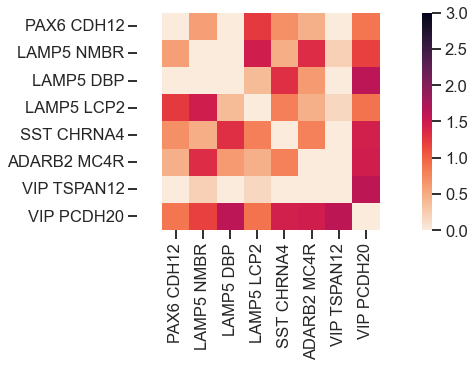

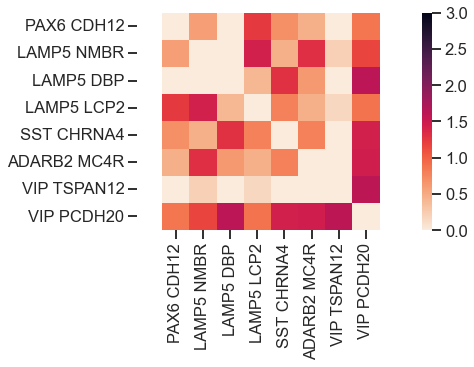

PAX6 CDH12  LAMP5 NMBR  LAMP5 DBP  LAMP5 LCP2  SST CHRNA4  \
PAX6 CDH12     0.000000   -0.002737   0.000179    0.004052    0.001668   
LAMP5 NMBR    -0.002737    0.000000   0.000274    0.019510    0.004155   
LAMP5 DBP      0.000179    0.000274   0.000000   -0.013377    0.001815   
LAMP5 LCP2     0.004052    0.019510  -0.013377    0.000000    0.002199   
SST CHRNA4     0.001668    0.004155   0.001815    0.002199    0.000000   
ADARB2 MC4R    0.002090    0.017005  -0.008513    0.002487   -0.001425   
VIP TSPAN12    0.002008    0.008445  -0.000724    0.001050   -0.000768   
VIP PCDH20     0.006792    0.022387   0.000576    0.001415    0.000259   

             ADARB2 MC4R  VIP TSPAN12  VIP PCDH20  
PAX6 CDH12      0.002090     0.002008    0.006792  
LAMP5 NMBR      0.017005     0.008445    0.022387  
LAMP5 DBP      -0.008513    -0.000724    0.000576  
LAMP5 LCP2      0.002487     0.001050    0.001415  
SST CHRNA4     -0.001425    -0.000768    0.000259  
ADARB2 MC4R     0.000000     0.000333    0.006973  
VIP TSPAN12     0.000333     0.000000    0.006724  
VIP PCDH20      0.006973     0.006724    0.000000

In [79]:
clf = GaussianNB()
df1 = cp.plot_dprime(clf, ephys_data, complete_features, cluster, metric=cp.dprime_gaussian, method='predict_log_proba');
clf = GaussianNB(priors=(0.5, 0.5))
df2 = cp.plot_dprime(clf, ephys_data, complete_features, cluster, metric=cp.dprime_gaussian, method='predict_log_proba');
df1 - df2

## Subclass dprime

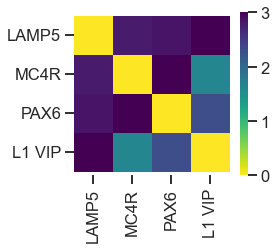

In [21]:
clf = RandomForestClassifier(class_weight='balanced_subsample')
data = ephys_data.query('core_l1_type')
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, complete_features, cluster='homology_type');

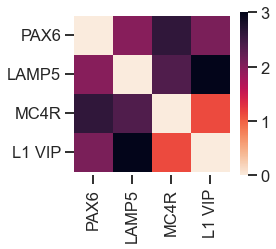

In [97]:
# clf = GaussianNB()
clf = RandomForestClassifier(class_weight='balanced')
clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
data, clusters = subset_data(
    human_df.loc[lambda df: (df.collaborator=="AIBS") & df.core_l1_type], 
    ephys_features, cluster='homology_type', ephys_frac_min=0, cluster_min=5)
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, complete_features, cluster='homology_type', cluster_list=subclasses);

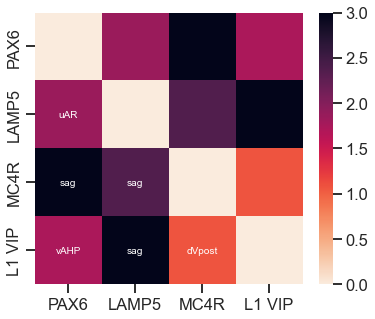

In [103]:
# clf = RandomForestClassifier(class_weight='balanced')
# ranking=lambda clf: clf.feature_importances_
clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
ranking = lambda clf: np.abs(clf.coef_[0,:])
clf = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear')
dprime, records = cp.pairwise_cluster_distances(clf, data, complete_features, ranking=ranking,
                                                cluster_label='homology_type', details=True)
plot_dprime_features(dprime, records)

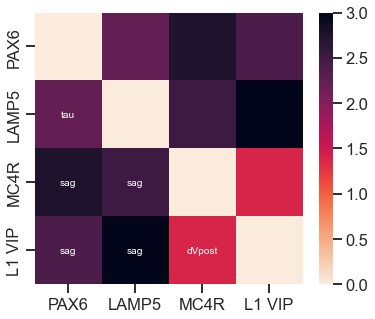

In [104]:
clf = RandomForestClassifier(class_weight='balanced')
dprime, records = cp.pairwise_cluster_distances(clf, data, ephys_features, 
                                                ranking=lambda clf: clf.feature_importances_,
                                                cluster_label='homology_type', details=True)
plot_dprime_features(dprime, records)

In [31]:
df = pd.DataFrame.from_records(records, index=['cluster_1', 'cluster_2'])
df['short_feat'] = df['feature'].map(short_feat)

pairwise_features = df.feature.unique()
pairwise_features

array(['low_freq_impedance_chirp', 'sag', 'postap_slope_ramp'],
      dtype=object)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:108: RuntimeWarning: invalid value encountered in less
  constant_mask = scale < 10 * np.finfo(scale.dtype).eps


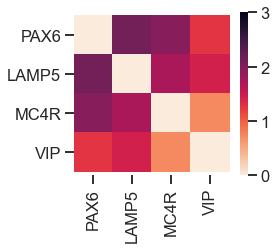

In [139]:
plt.figure(figsize=(3.5,3))
plot_dprime(clf, data, ephys_features, cluster='homology_type', cv=LeaveOneOut());

## Morpho dprime

In [59]:
data = human_df.query('core_l1_type')
# data = human_df.query('l1_type')
features = morph_features
data = subset_data(data, features, ephys_frac_min=0, cluster_min=0)
data.homology_type.value_counts(dropna=False)

LAMP5     29
PAX6      19
MC4R      12
L1 VIP     4
Name: homology_type, dtype: int64

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


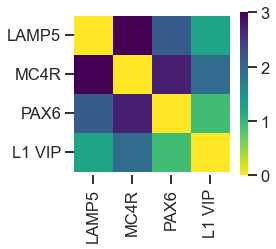

In [65]:
# clf = GaussianNB()
clf = RandomForestClassifier(class_weight='balanced_subsample')
# clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
# clf = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear')
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, morph_features, cluster='homology_type');

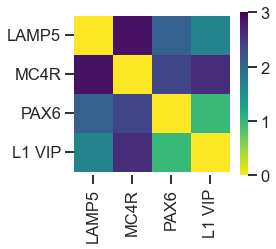

In [61]:
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, morph_features, cluster='homology_type', cv=ms.LeaveOneOut());

### t-type level

In [276]:
data = human_df.query('l1_type')
ttype_data, clusters = subset_data(data, features, ephys_frac_min=0, cluster_min=5)

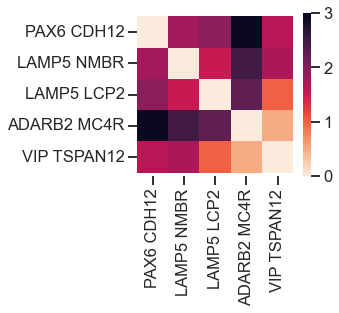

In [277]:
plt.figure(figsize=(3.5,3))
clf = RandomForestClassifier(class_weight='balanced')
cp.plot_dprime(clf, ttype_data, morph_features, cluster=cluster);

In [238]:

morph_dprime, records = cp.pairwise_cluster_distances(clf, ttype_data, features, cluster, details=False)

In [83]:

dist, records = cp.ova_cluster_distances(clf, data, features, cluster)
df = pd.DataFrame.from_records(records, index='cluster')

<AxesSubplot:>

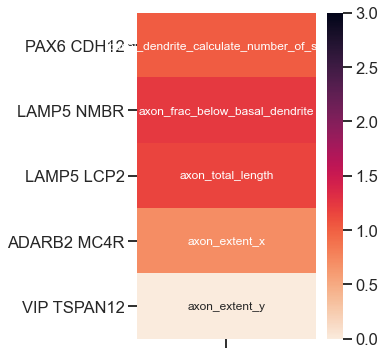

In [84]:
# overall dprime
fig, ax = plt.subplots(figsize=(4,6))
annot=df.loc[df['rank']==0, ['feature']]
sns.heatmap(dist[:,None], yticklabels=clusters, xticklabels=[''], annot=annot, fmt='s', cmap='rocket_r',
            annot_kws=dict(size=12), vmin=0, vmax=3,
           cbar=True, ax=ax)

<AxesSubplot:xlabel='rank'>

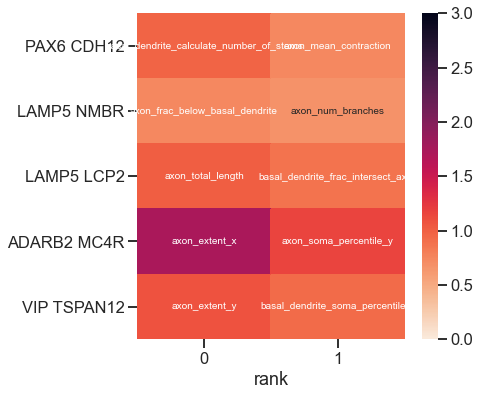

In [85]:
# Not cross-validated!
df2 = df.reset_index().pivot(index='cluster', columns='rank', values=['dprime','feature']).loc[clusters]

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df2['dprime'].astype('float'), cmap='rocket_r',  annot=df2['feature'], fmt='s', 
            annot_kws=dict(size=10),  cbar=True, ax=ax, vmin=0, vmax=3,)

### combined m/e

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:112: RuntimeWarning: invalid value encountered in less
  constant_mask = scale < 10 * np.finfo(scale.dtype).eps


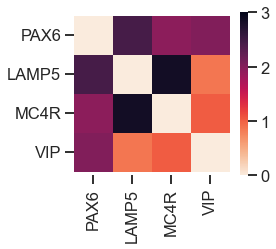

In [275]:
# need to exclude collab cells, etc?
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, list(morph_features)+list(ephys_features), cluster='homology_type');

## Mouse

### Ephys

In [254]:
reload(cp)

<module 'patchseq_utils.cluster_pairs' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/cluster_pairs.py'>

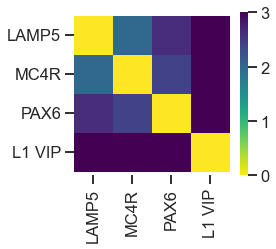

In [65]:
# clf = GaussianNB()
clf = RandomForestClassifier(class_weight='balanced_subsample')
# clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
data = mouse_df
data = mouse_df.loc[lambda df: df.structure.str.contains('VIS')]
data = subset_data(data, ephys_features, ephys_frac_min=0, cluster_min=5, cluster='homology_type')
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, complete_features, cluster='homology_type', cluster_list=subclasses);

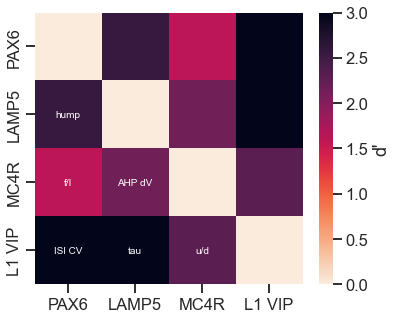

In [116]:
# clf = RandomForestClassifier(class_weight='balanced')
# ranking=lambda clf: clf.feature_importances_
clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
ranking = lambda clf: np.abs(clf.coef_[0,:])
clf = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear')
dprime, records = cp.pairwise_cluster_distances(clf, data, complete_features, ranking=ranking,
                                                cluster_label='homology_type', details=True)
cp.plot_dprime_features(dprime, records)

In [77]:
df = pd.DataFrame.from_records(records, index=['cluster_1', 'cluster_2'])
df['short_feat'] = df['feature'].map(short_feat)

pairwise_features = df.feature.unique()
pairwise_features

array(['sag_area', 'upstroke_downstroke_ratio_ramp', 'threshold_i_ramp',
       'fast_trough_deltav_hero', 'rheobase_i'], dtype=object)

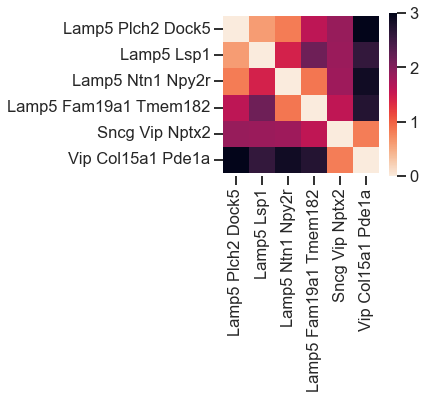

In [72]:
data, clusters = subset_data(data, ephys_features, ephys_frac_min=0, cluster_min=5)
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, complete_features, cluster=cluster);

### Morph

In [39]:
subclasses = ['LAMP5', 'MC4R', 'PAX6', 'L1 VIP']

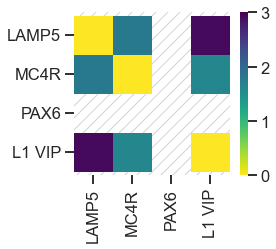

In [41]:
data = mouse_df
data = subset_data(data, morph_features, ephys_frac_min=0, cluster_min=5, cluster='homology_type')
plt.figure(figsize=(3.5,3))
clf = RandomForestClassifier(class_weight='balanced_subsample')
# clf = LogisticRegression(penalty='l1', class_weight='balanced', solver='liblinear')
cp.plot_dprime(clf, data, morph_features, cluster='homology_type', cluster_list=subclasses);

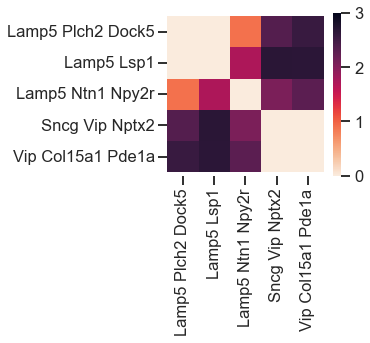

In [75]:
data = mouse_df
data, clusters = subset_data(data, morph_features, ephys_frac_min=0, cluster_min=5, cluster=cluster)
plt.figure(figsize=(3.5,3))
cp.plot_dprime(clf, data, morph_features, cluster=cluster);

## Transcriptomics

### dispersion

In [152]:
def plot_dispersion(stats, name):
    sns.scatterplot(data=stats.T, x='mean', y='std', alpha=0.5, s=10)
    xmax = 5*np.quantile(stats.T.mean(), 0.99)
    plt.xlim(0,xmax)
    plt.ylim(0,xmax)
    
    xx = np.linspace(0,xmax, 500)
    plt.plot(xx, (xx + (xx**2)/1.)**(1/2), 'r')
    plt.plot(xx, (xx + (xx**2)/2.)**(1/2), 'g')
    plt.title(name)
    plt.show()
    
def plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=False):
    shiny_df = shiny_df[shiny_df[type_col].isin(type_list)]
    if mask_zeros:
        get_stats = lambda df: df.replace(0, np.nan).agg(['mean', 'std'])
    else:
        get_stats = lambda df: df.agg(['mean', 'std'])
        

    stats = shiny_df[gene_list].pipe(get_stats)
    plot_dispersion(stats, 'All')
    for name in type_list:
        stats = shiny_df.loc[lambda df: df[type_col]==name, gene_list].pipe(get_stats)
        plot_dispersion(stats, name)

In [69]:
names_df = pd.read_csv("/home/tom.chartrand/projects/human_l1/human_MTG_cluster_conversion.csv")
full_names_update = (names_df.set_index(names_df['patchseq_cluster'])
                ['current_FACS_cluster'].to_dict())
import ateam.data.shiny as shiny

l1_types_human_ps = [
        "Inh L1-2 PAX6 CDH12",
        "Inh L1-2 PAX6 TNFAIP8L3",
        "Inh L1 SST NMBR (ADARB2+)",
        "Inh L1-2 LAMP5 DBP",
        "Inh L1-4 LAMP5 LCP2 (rosehip)",
        "Inh L1 SST CHRNA4 (ADARB2+)",
        "Inh L1-2 GAD1 MC4R (ADARB2+)",
        # "Inh L1-3 PAX6 SYT6 (Sncg)",
        "Inh L1-2 VIP TSPAN12",
        "Inh L1-2 SST BAGE2 (ADARB2+)",
        "Inh L1-2 VIP PCDH20",
]
l1_types_human_facs = [full_names_update[x] for x in l1_types_human_ps]


gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

747

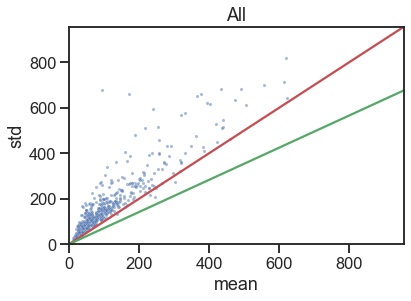

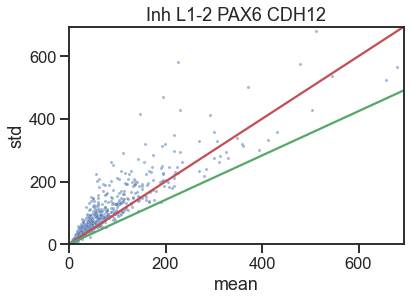

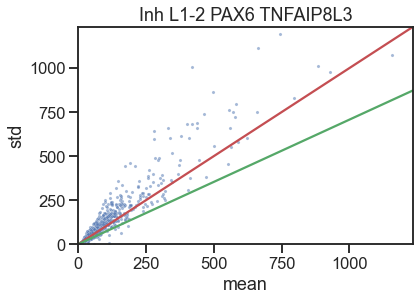

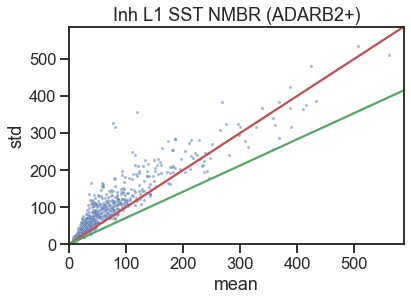

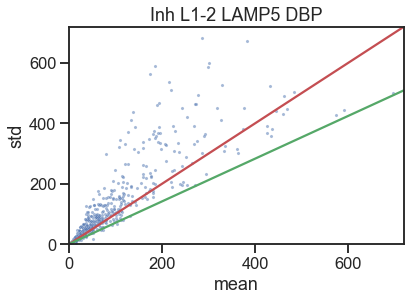

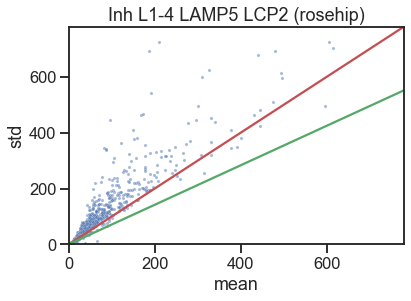

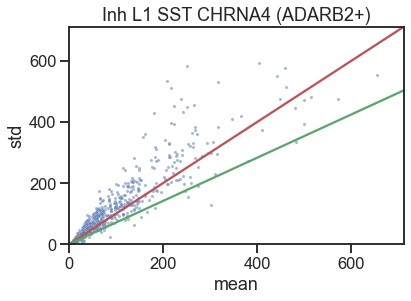

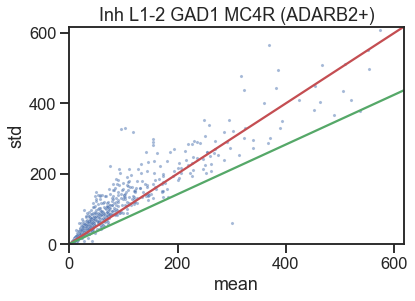

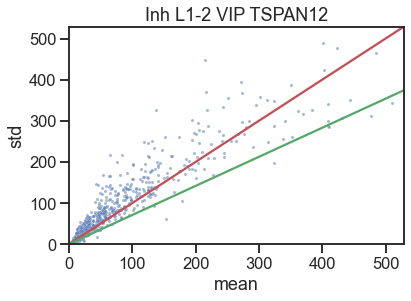

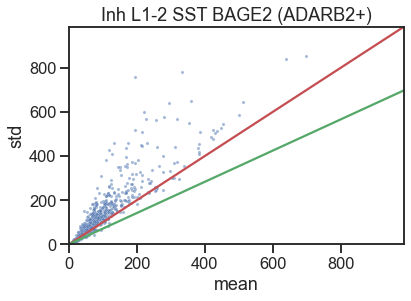

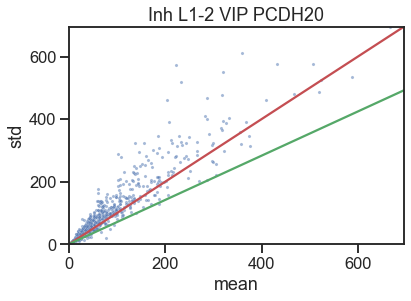

In [159]:
shiny_dir = shiny.shiny_directory('human')
shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=True)

type_col='topLeaf'
type_list = l1_types_human_ps
plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=True)

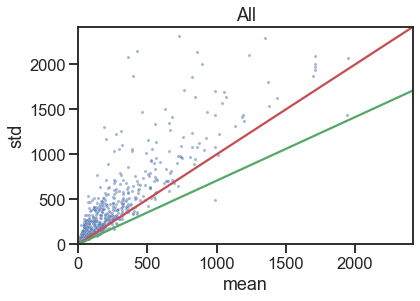

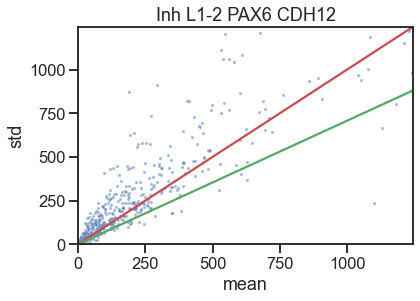

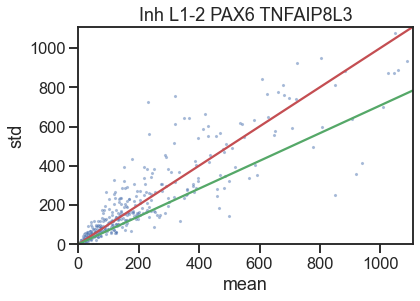

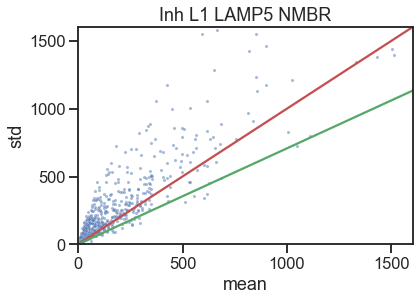

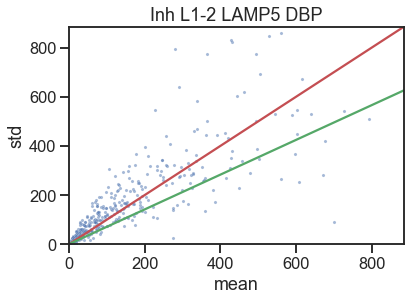

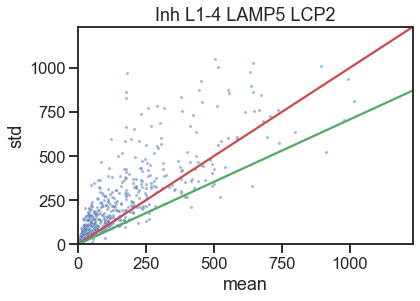

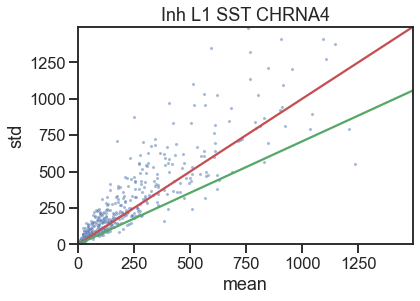

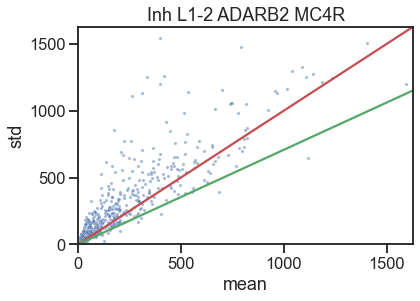

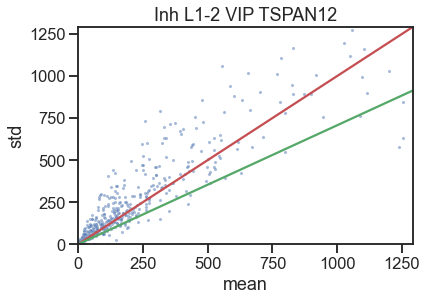

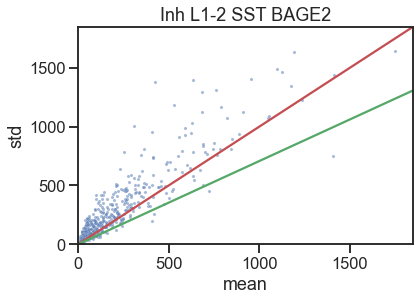

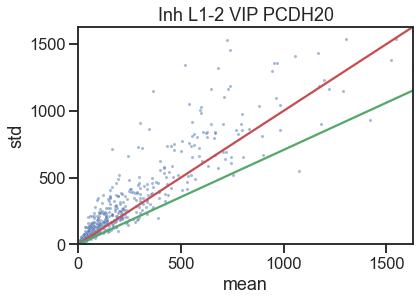

In [160]:
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=False)

type_col='cluster'
type_list = l1_types_human_facs
plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=True)

### marker correlation

In [66]:
def get_group_means(shiny_dir, type_col, type_list, gene_list, ps=True):
    shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=ps)
    if ps:
        shiny_df[type_col] = shiny_df[type_col].map(full_names_update)
    shiny_df = shiny_df[shiny_df[type_col].isin(type_list)]
    shiny_df[gene_list] = shiny_df[gene_list].transform(lambda x: np.log(1+x))
    res = shiny_df.groupby(type_col)[gene_list].agg('mean')
    return res

In [70]:
shiny_dir = shiny.shiny_directory('human')
type_col='topLeaf'
type_list = l1_types_human_facs
ps_means = get_group_means(shiny_dir, type_col, type_list, gene_list)

shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
type_col='cluster'
facs_means = get_group_means(shiny_dir, type_col, type_list, gene_list, ps=False)

r=0.84, p=0


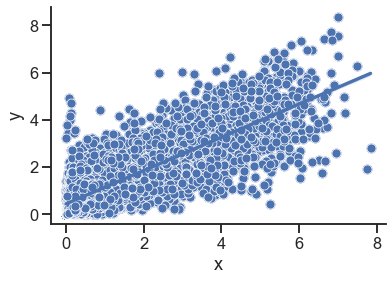

In [75]:
data = pd.DataFrame(dict(x=facs_means.values.flatten(), y=ps_means.values.flatten()))
plot_corr(data=data, x="x", y='y', spearman=False)

Text(0.5, 0, 'snRNA-seq')

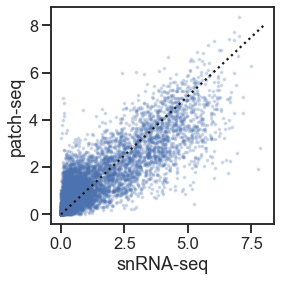

In [288]:
plt.figure(figsize=(4,4))
plt.scatter(x=facs_means.values[:], y=ps_means.values[:], alpha=0.2, s=5)

xmax = 8
plt.plot([0, xmax], [0, xmax], ':k')
plt.ylabel('patch-seq')
plt.xlabel('snRNA-seq')

In [161]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

4020

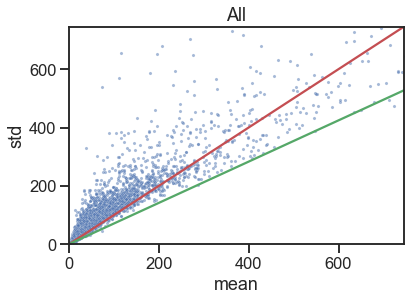

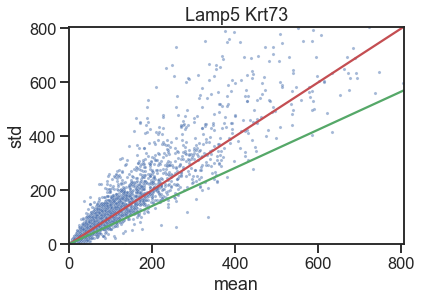

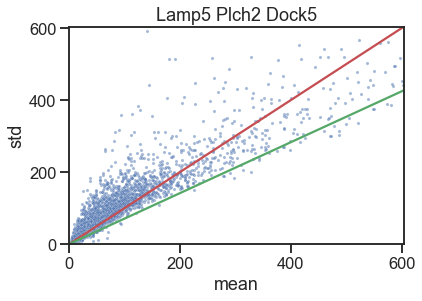

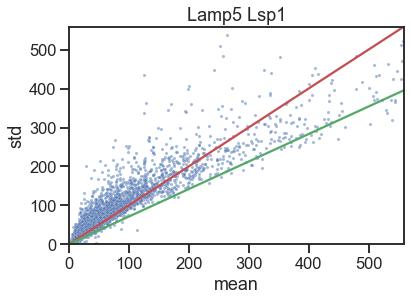

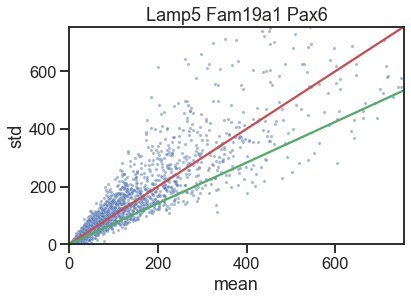

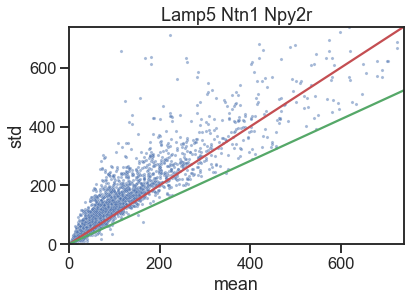

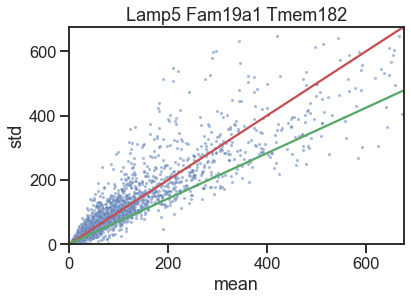

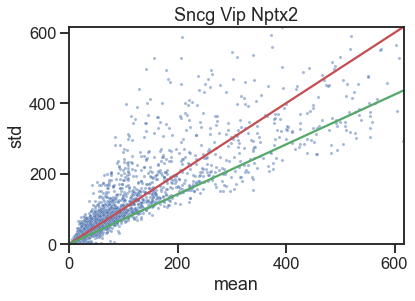

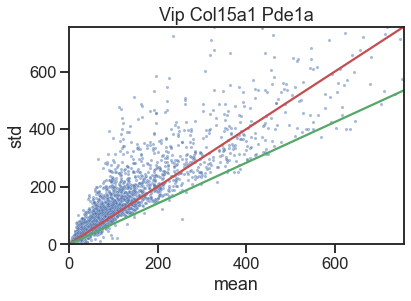

In [162]:
shiny_dir = shiny.shiny_directory('mouse')
shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=True)

type_col='topLeaf'
type_list = ttypes_mouse.categories
plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=True)

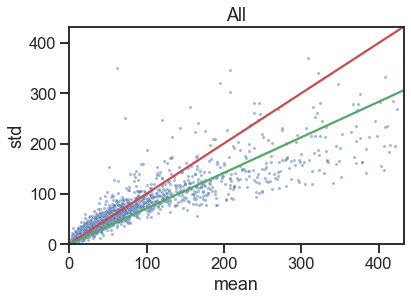

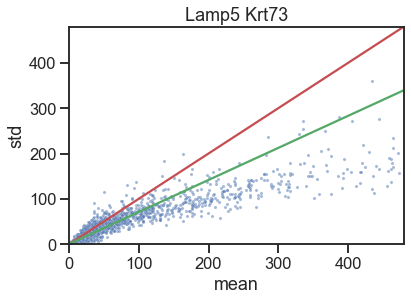

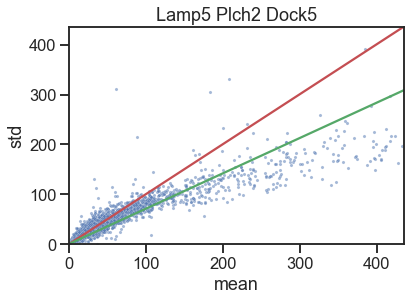

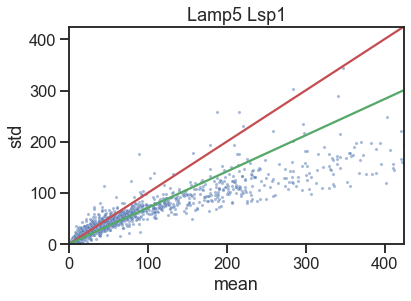

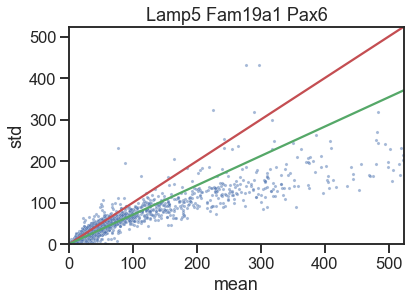

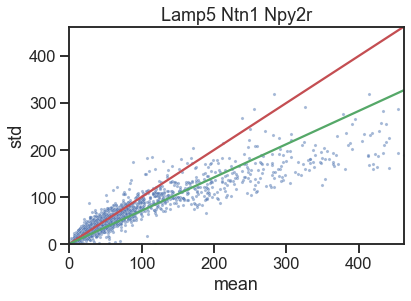

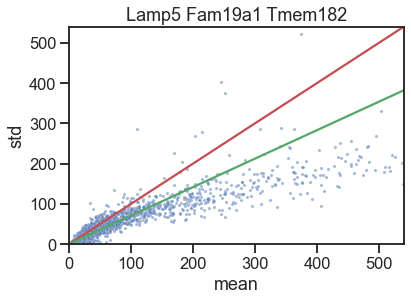

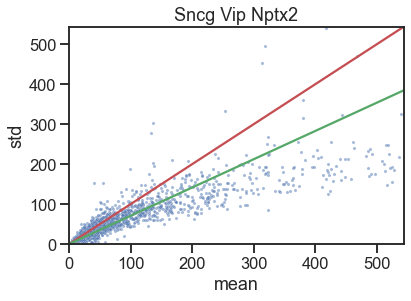

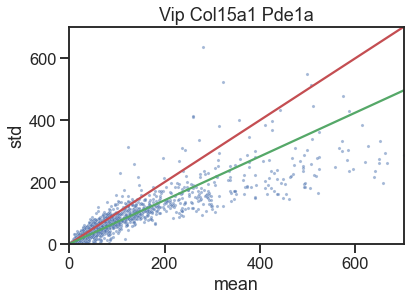

In [163]:
shiny_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/Mm_VISp_AIT2.3.0_20047_202005"
shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=False)

type_col='cluster'
type_list = ttypes_mouse.categories
plot_dispersion_all(shiny_df, gene_list, type_col, type_list, mask_zeros=True)

### dprime

In [22]:
import scipy.spatial.distance as distance
def get_shiny_genes(shiny_dir, gene_list, type_col='topLeaf', nms_pass=True, transforms=[], species='human'):
    shiny_df = shiny.load_genes_shiny(gene_list, directory=shiny_dir, nms_pass=nms_pass)
    shiny_df['t-type'] = shiny_df[type_col]
    for fcn in transforms:
        shiny_df['t-type'] = shiny_df['t-type'].map(fcn)
    if species=='human':
        shiny_df['subclass'] = shiny_df['t-type'].map(homology_mapping_human)
    if species=='mouse':
        shiny_df['subclass'] = shiny_df['t-type'].map(homology_mapping_mouse)
    # in case some requested genes are missing
    gene_list = shiny_df.columns.intersection(gene_list)
    return shiny_df, gene_list

def get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=None, normalize=False, log=False):
    if type_list is not None:
        shiny_df = shiny_df[shiny_df[type_col].isin(type_list)].copy()
    if query is not None:
        shiny_df = shiny_df.query(query)
    gene_list = shiny_df.columns.intersection(gene_list)
    data = shiny_df[gene_list].values
    # Normalization
    if normalize:
        cell_totals = data.sum(axis=1)
        avg_total = cell_totals.mean()
        data = avg_total * data / cell_totals[:, np.newaxis]
    if log:
        data = np.log(data+1)
    shiny_df[gene_list] = data
    print("using data with shape {}".format(data.shape))
    return shiny_df

def tx_dprime(df, features, cluster_label, type_list=None, n_folds=5, r=3, zero_inflated=True, **kwargs ):
    type_labels = df[cluster_label]
    data = df[features].values
    if type_list is None:
        type_list = type_labels.unique()
    # d-prime calculation
    if zero_inflated:
        dprime_results = dprime.zinb_dprime(
            data, type_list, type_labels, n_folds=n_folds,
            r=r, **kwargs)
    else:
        dprime_results = dprime.negative_binomial_dprime(
            data, type_list, type_labels, n_folds=n_folds,
            r=r, **kwargs)

    dprime_mat = distance.squareform(
        [np.abs(dprime_results[k]["dprime"]) for k in dprime_results])
    output_dprime_df = pd.DataFrame(dprime_mat, index=type_list, columns=type_list)
#     return output_dprime_df, dprime_results
    return output_dprime_df

def tx_dprime_new(df, features, cluster_label, type_list=None, n_folds=5, **kwargs):
    type_labels = df[cluster_label]
    data = df[features].values
    if type_list is None:
        type_list = type_labels.unique()
    dprime_results = dprime.zinb_dprime_fit_phi(
            data, type_list, type_labels, n_folds=n_folds,
            spaced_log_mu=spaced_log_mu, pi_lookup=fit_pi, phi_lookup=fit_phi, **kwargs)

    dprime_mat = distance.squareform(
        [np.abs(dprime_results[k]["dprime"]) for k in dprime_results])
    output_dprime_df = pd.DataFrame(dprime_mat, index=type_list, columns=type_list)
#     return output_dprime_df, dprime_results
    return output_dprime_df

In [20]:
reload(dprime)

<module 'patchseq_utils.dprime' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/dprime.py'>

In [76]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', 
                      index_col=0)['Gene'].tolist()
shiny_dir = shiny.shiny_directory('human')
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col='topLeaf', nms_pass=True, 
                     transforms=[shorten_name, names_update], species='human')
shiny_df = shiny_df.query("contam_sum<2")

In [79]:
shiny_df.loc[shiny_df['topLeaf'].str.contains("TNFAIP"), 'layer'].value_counts()

1          9
2          5
3          4
STRvACB    4
4          1
PCx3       1
_5         1
HIPbCA1    1
5          1
Name: layer, dtype: int64

In [46]:
shiny_df = shiny_df.loc[human_df.index]

shiny_df['t-type'].value_counts().loc[ttypes_human.categories]

In [48]:
shiny_df = shiny_df.loc[shiny_df['t-type']!='PAX6 TNFAIP8L3']
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_human.categories, log=True, normalize=False)

using data with shape (238, 747)


### LDA etc

In [135]:
# clf = LogisticRegression(class_weight='balanced', C=0.1)
clf = LinearDiscriminantAnalysis()
ps_dprime_lda, _ = cp.pairwise_cluster_distances(clf, data, gene_list, 't-type')

(0.0, 10.0, 10.0, 0.0)

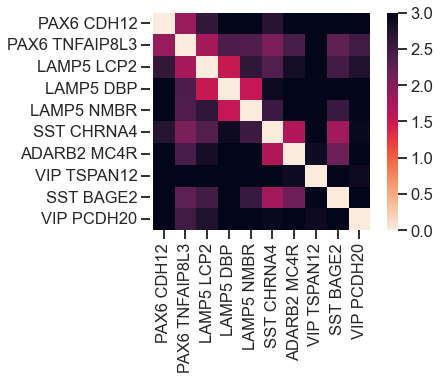

In [136]:
plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_lda.loc[ttypes_human.categories,ttypes_human.categories],
            cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')

In [50]:
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_human.categories, log=False, normalize=False)

using data with shape (608, 747)


0


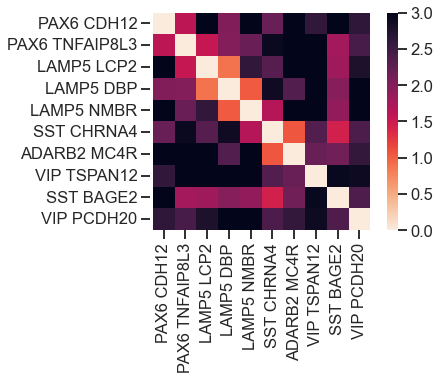

In [115]:
k = 1
ps_dprime = tx_dprime(data, gene_list, 't-type', zero_inflated=False, r=3)#, reg_num=k, reg_den=k)

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime.loc[ttypes_human.categories,ttypes_human.categories], cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

In [200]:
reload(dprime)

<module 'patchseq_utils.dprime' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/dprime.py'>

### ZINB

In [49]:
k = 1
ps_dprime_zinb = tx_dprime_new(data, gene_list, 't-type', reg_num=k, reg_den=k)

0


In [52]:
reload(cp)

<module 'patchseq_utils.cluster_pairs' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/cluster_pairs.py'>

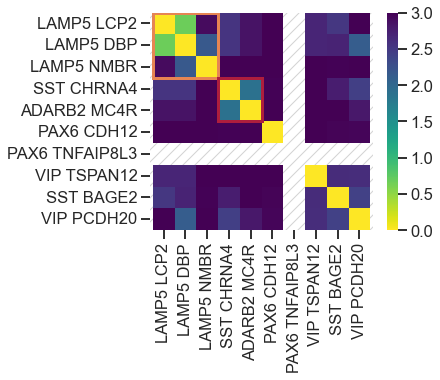

In [54]:
plt.figure(figsize=(5,4))
# sns.heatmap(ps_dprime_zinb.loc[ttypes_human.categories,ttypes_human.categories], cmap='viridis_r', vmin=0, vmax=3, cbar=True)
# plt.axis('equal')
cp.plot_dprime_data(ps_dprime_zinb, cluster_list=ttypes_human.categories)
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
# ax.add_patch(Rectangle((5,5), 2, 2, edgecolor=palette_subclass['PAX6'], **args))
plt.show()

0


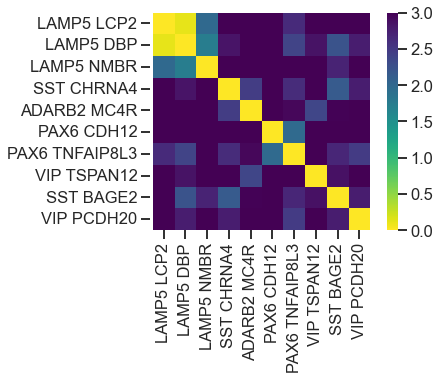

In [41]:
k = 10
ps_dprime_zinb = tx_dprime_new(data, gene_list, 't-type', reg_num=k, reg_den=k)

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_zinb.loc[ttypes_human.categories,ttypes_human.categories], cmap='viridis_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

0


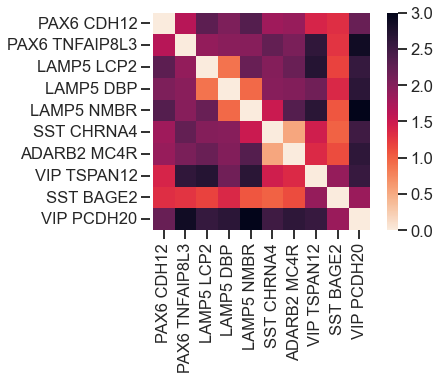

In [32]:
ps_dprime = tx_dprime(data, gene_list, 't-type', zero_inflated=True, r=1)

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime.loc[ttypes_human.categories,ttypes_human.categories], cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

### subclass

In [56]:
data = get_gene_data(shiny_df, gene_list, query="subclass!='other'", log=False, normalize=False)
subclasses = ['PAX6', 'LAMP5', 'MC4R', 'L1 VIP']

using data with shape (237, 747)


/tmp/ipykernel_13107/1799026157.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shiny_df[gene_list] = data


In [57]:
k = 1

human_subclass_dprime = tx_dprime_new(data, gene_list, 'subclass', 
                                      type_list=subclasses, reg_num=k, reg_den=k)

0


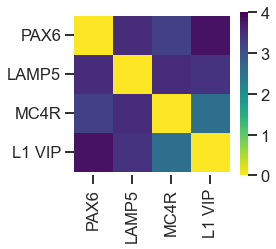

In [58]:
plt.figure(figsize=(3.5, 3))
sns.heatmap(human_subclass_dprime, cmap='viridis_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

/tmp/ipykernel_12046/3539787820.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shiny_df[gene_list] = data


using data with shape (4237, 747)
0


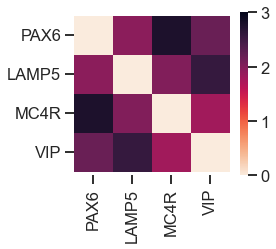

In [129]:

human_subclass_dprime = tx_dprime(data, gene_list, 'subclass', type_list=subclasses, 
                                  zero_inflated=False, r=1)

plt.figure(figsize=(3.5, 3))
sns.heatmap(human_subclass_dprime, cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

### SCT gene list

In [208]:
from pyreadr import read_r
sct = read_r(projectdir/"seurat_sct_human_ps.rda")['x'].T
# sct = human_df.join(sct.T, on='sample_id', how='inner')

In [209]:
gene_list = sct.columns.to_list()
shiny_dir = shiny.shiny_directory('human')
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col='topLeaf', nms_pass=True, 
                     transforms=[shorten_name, names_update], species='human')
shiny_df = shiny_df.query("contam_sum<2")
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_human.categories, log=False, normalize=False)

using data with shape (608, 3000)


In [90]:
# clf = LogisticRegression(class_weight='balanced', C=0.1)
clf = LinearDiscriminantAnalysis()
ps_dprime_lda, _ = cp.pairwise_cluster_distances(clf, data, gene_list, 't-type')

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_lda.loc[l1_types_human, l1_types_human],
            cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')

In [210]:
shiny_df = shiny_df.query("contam_sum<2")
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_human.categories, log=False, normalize=False)

using data with shape (608, 3000)


In [181]:
reload(dprime)

<module 'patchseq_utils.dprime' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/dprime.py'>

0


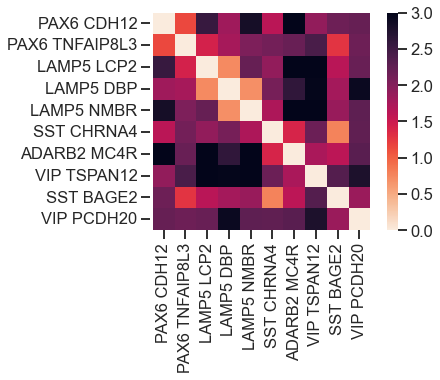

In [212]:
k = 1
ps_dprime_sctgene = tx_dprime_new(data, gene_list, 't-type', reg_num=k, reg_den=k)

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_sctgene.loc[l1_types_human, l1_types_human], cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

0


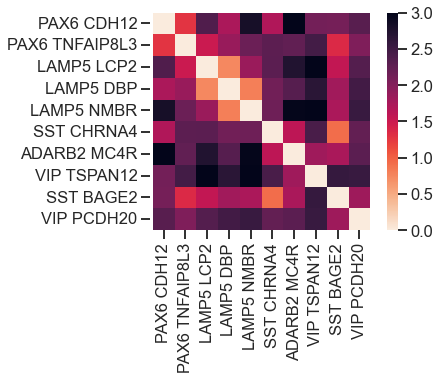

In [186]:
k = 10
ps_dprime_sctgene = tx_dprime_new(data, gene_list, 't-type', reg_num=k, reg_den=k)

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_sctgene.loc[l1_types_human, l1_types_human], cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

0


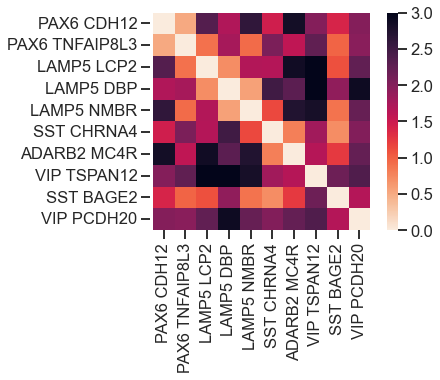

In [188]:
ps_dprime_sctgene = tx_dprime(data, gene_list, 't-type', zero_inflated=False, r=1)

plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_sctgene.loc[l1_types_human, l1_types_human], cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

/tmp/ipykernel_12046/3539787820.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shiny_df[gene_list] = data


using data with shape (4237, 3000)
0


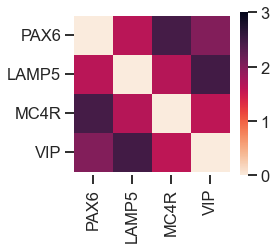

In [127]:
data = get_gene_data(shiny_df, gene_list, query="subclass!='other'", log=False, normalize=False)
subclasses = ['PAX6', 'LAMP5', 'MC4R', 'VIP']
human_subclass_dprime = tx_dprime(data, gene_list, 'subclass', type_list=subclasses, 
                                  zero_inflated=False, r=1)

plt.figure(figsize=(3.5, 3))
sns.heatmap(human_subclass_dprime, cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

In [124]:
data = get_gene_data(shiny_df, gene_list, query="subclass!='other'", log=False, normalize=True)
subclasses = ['PAX6', 'LAMP5', 'MC4R', 'VIP']
human_subclass_dprime = tx_dprime(data, gene_list, 'subclass', type_list=subclasses, 
                                  zero_inflated=False, r=1)

plt.figure(figsize=(3.5, 3))
sns.heatmap(human_subclass_dprime, cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

### all genes

In [296]:
gene_list = list(pd.read_csv(
    "/home/tom.chartrand/projects/patchseq_human_L23/data/gene_names.csv", 
    index_col=0).values[:,0])
shiny_dir = shiny.shiny_directory('human')
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col='topLeaf', nms_pass=True, 
                     transforms=[shorten_name, names_update], species='human')
data = get_gene_data(shiny_df, gene_list, type_col='t-type', query="contam_sum<2",
                  type_list=ttypes_human.categories)

/tmp/ipykernel_3023/1799026157.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shiny_df[gene_list] = data


KeyboardInterrupt: 

In [ ]:
k = 1
ps_dprime_all = tx_dprime_new(data, gene_list, 't-type', reg_num=k, reg_den=k)

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_sctgene, cmap='viridis_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

### FACS

In [66]:
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'

In [73]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', 
                      index_col=0)['Gene'].tolist()
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col='cluster', nms_pass=False, 
                     transforms=[shorten_name], species='human')

In [75]:
shiny_df.loc[shiny_df['cluster'].str.contains("TNFAIP"), 'layer'].value_counts()

L1    7
L2    6
L5    2
L3    1
Name: layer, dtype: int64

In [72]:
shiny_df = shiny_df.query("layer=='L1'")

shiny_df['t-type'].value_counts().loc[ttypes_human.categories]

LAMP5 LCP2         46
LAMP5 DBP          17
LAMP5 NMBR        229
SST CHRNA4         48
ADARB2 MC4R        78
PAX6 CDH12         62
PAX6 TNFAIP8L3      7
VIP TSPAN12        26
SST BAGE2          65
VIP PCDH20         33
Name: t-type, dtype: int64

In [69]:
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_human.categories, log=False, normalize=False)

using data with shape (611, 747)


In [18]:
# clf = LogisticRegression(class_weight='balanced', C=0.1)
clf = LinearDiscriminantAnalysis()
ps_dprime_lda, _ = cp.pairwise_cluster_distances(clf, data, gene_list, 't-type')

(0.0, 10.0, 10.0, 0.0)

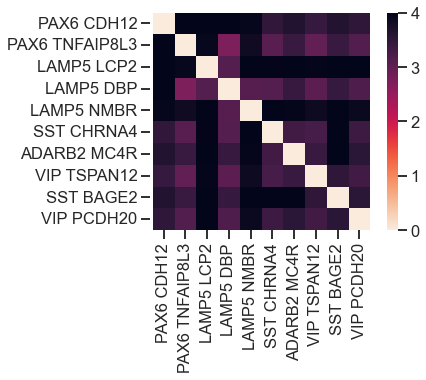

In [21]:
plt.figure(figsize=(5,4))
sns.heatmap(ps_dprime_lda.loc[ttypes_human.categories,ttypes_human.categories],
            cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')

In [70]:
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_human.categories, log=False, normalize=False)

# types = l1_types_human+["Inh L1-2 VIP LBH"]
types = l1_types_human
facs_dprime = tx_dprime(data, gene_list, type_list=types, zero_inflated=False, r=1,
                        cluster_label='t-type')

using data with shape (611, 747)
0


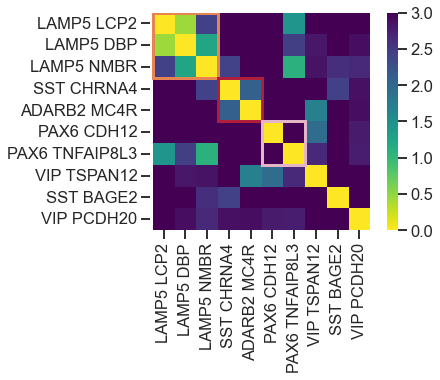

In [71]:
plt.figure(figsize=(5,4)
sns.heatmap(facs_dprime, cmap='viridis_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
ax.add_patch(Rectangle((5,5), 2, 2, edgecolor=palette_subclass['PAX6'], **args))
plt.show()

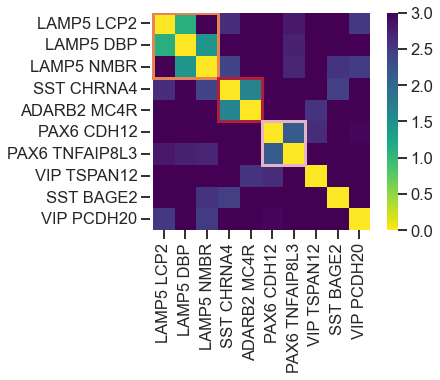

In [21]:
plt.figure(figsize=(5,4))
# <2.2
sns.heatmap(facs_dprime, cmap='viridis_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
ax.add_patch(Rectangle((5,5), 2, 2, edgecolor=palette_subclass['PAX6'], **args))
plt.show()

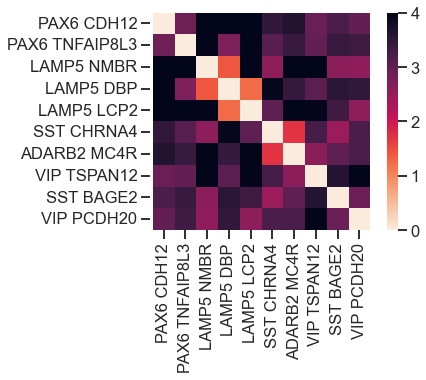

In [281]:
plt.figure(figsize=(5,4))
sns.heatmap(facs_dprime, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

## mouse TX

### FACS

In [76]:
shiny_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/Mm_VISp_AIT2.3.0_20047_202005"
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

4020

In [77]:
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col='cluster', nms_pass=False, 
                      species='mouse')

using data with shape (1145, 4020)


In [79]:
data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_mouse.categories, log=False, normalize=False)

# types = l1_types_human+["Inh L1-2 VIP LBH"]
types = l1_types_mouse
facs_dprime = tx_dprime(data, gene_list, type_list=types, zero_inflated=False, r=1,
                        cluster_label='t-type')

using data with shape (1145, 4020)
0


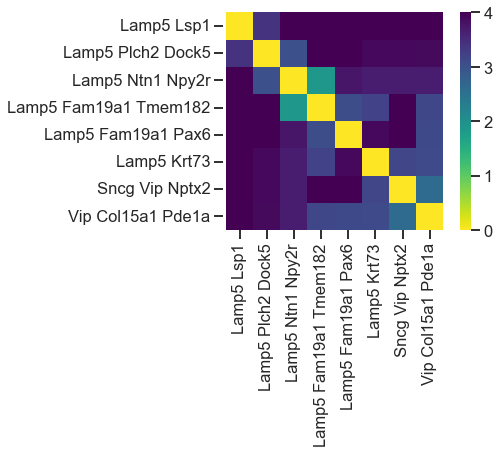

In [81]:
plt.figure(figsize=(5,4))
sns.heatmap(facs_dprime, cmap='viridis_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

### PS

In [227]:
import h5py
f = h5py.File("/home/tom.chartrand/projects/human_l1/zinb_mouse.h5", "r")
spaced_log_mu = f['regularizations/spaced_log_mu'][...]
fit_phi = f['regularizations/phi_kr_fit'][...]
fit_pi = f['regularizations/pi_sig_fit'][...]
f.close()

In [228]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv', 
                      index_col=0)['Gene'].tolist()
len(gene_list)

4020

In [232]:
shiny_dir = shiny.shiny_directory('mouse')
type_col='topLeaf'
shiny_df, gene_list = get_shiny_genes(shiny_dir, gene_list, type_col=type_col, species='mouse')

In [235]:
shiny_df = shiny_df[shiny_df['structure'].fillna('').str.contains('VIS')]

data = get_gene_data(shiny_df, gene_list, type_col='t-type', 
                  query=None, type_list=ttypes_mouse.categories, log=False, normalize=False)

using data with shape (819, 4020)


0


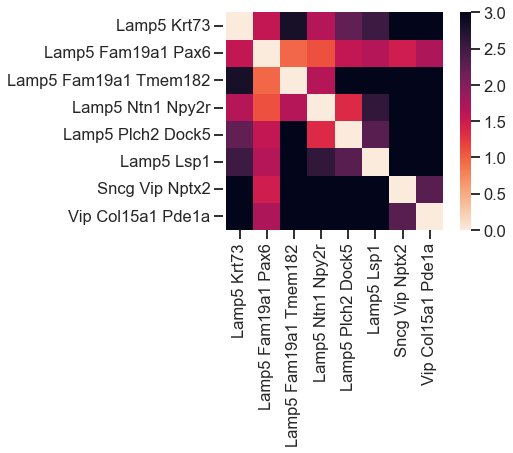

In [242]:
k = 1
mouse_ps_dprime = tx_dprime_new(data, gene_list, 't-type', reg_num=k, reg_den=k)

plt.figure(figsize=(5,4))
sns.heatmap(mouse_ps_dprime, cmap='rocket_r', vmin=0, vmax=3, cbar=True)
plt.axis('equal')
plt.show()

In [245]:
k = 1
mouse_subclass_dprime = tx_dprime_new(data, gene_list, 'subclass', reg_num=k, reg_den=k)

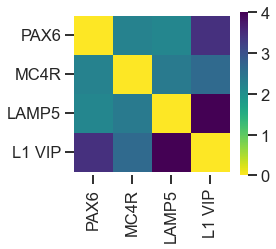

In [252]:
plt.figure(figsize=(3.5, 3))
sns.heatmap(mouse_subclass_dprime, cmap='viridis_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

## cross-modality correlation

In [33]:
def get_distances(df1, df2=None, name1='1', name2='2'):
    df1 = df1.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cols = df1.columns if df2 is None else df1.columns.intersection(df2.columns)
    dflat = df1.loc[cols, cols].unstack().rename(name1).to_frame()
    if df2 is not None:
        dflat = dflat.join(df2.loc[cols, cols].unstack().rename(name2))
    dflat = dflat.reset_index().loc[lambda df: df['level_0']>df['level_1']]
    dflat['pair_type'] = dflat.apply(lambda x: 'within' 
                                     if homology_mapping_human[x['level_0']] == homology_mapping_human[x['level_1']] 
                                 else 'between', axis=1)
    return dflat.set_index(['level_0', 'level_1'])

In [34]:
from scipy.stats import spearmanr, pearsonr
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.isotonic import IsotonicRegression
def plot_corr(data, x, y, spearman=True, smooth=True, ax=None, include_metrics=False, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    if spearman:
        corr, p = spearmanr(data[x], data[y], nan_policy='omit')
    else:
        corr, p = pearsonr(data[x], data[y])
    if not spearman:
        sns.regplot(data=data, x=x, y=y, ax=ax)
    sns.scatterplot(data=data, x=x, y=y, ax=ax, **kwargs)

    if spearman:
        if smooth:
            smoothed = lowess(data[y], data[x])
            ax.plot(*smoothed.T, 'grey')
        else:        
            xsmooth = np.linspace(min(data[x]), max(data[x]), 200)
            ysmooth = IsotonicRegression(increasing='auto').fit(data[x], data[y]).predict(xsmooth)
            ax.plot(xsmooth, ysmooth, 'grey')

    summary = f"r={corr:.2g}, p={p:.2g}"
    if include_metrics:
        ax.text(0.5, 0.99, summary, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='center')
    else:
        print(summary)
    sns.despine()

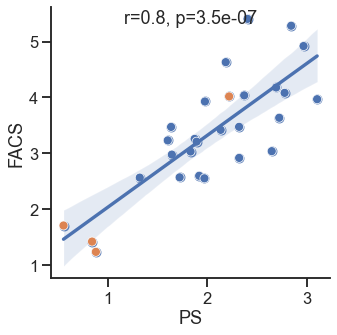

In [216]:
x = 'PS'
y = 'FACS'
dflat = get_distances(ps_dprime.loc[clusters, clusters], facs_dprime.loc[clusters, clusters], x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)

(0.42876827643906146,
 3.2295941757862803,
 0.31884717760414205,
 4.041995831501835)

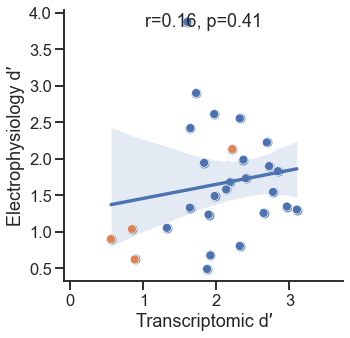

In [219]:
x = 'Transcriptomic d′'
y = 'Electrophysiology d′'
dflat = get_distances(ps_dprime, ephys_dprime, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.axis('equal')

In [ ]:
# dflat = dflat.join(get_distances(morph_dprime, name1='morph'), rsuffix='_r')
# sns.scatterplot(data=dflat.query("pair_type=='between'"), x=x, y=y,  hue='morph', legend=True, ax=ax)

# pcdh = (dflat.level_0=='VIP PCDH20') | (dflat.level_1=='VIP PCDH20') 

r=0.52, p=0.0049


(0.0, 4.0)

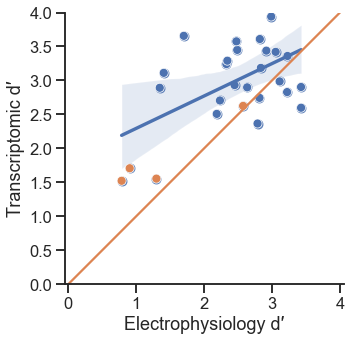

In [139]:
y = 'Transcriptomic d′'
x = 'Electrophysiology d′'
dflat = get_distances(ephys_dprime_rf, ps_dprime_lda, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.plot([0,4],[0,4])
plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

r=0.59, p=0.001


(0.0, 4.0)

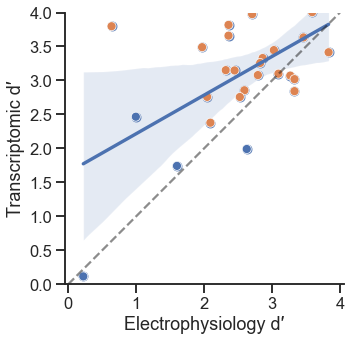

In [42]:
y = 'Transcriptomic d′'
x = 'Electrophysiology d′'
dflat = get_distances(ephys_dprime_log, ps_dprime_zinb, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.plot([0,4],[0,4], 'k--', alpha=0.5)
plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

r=0.5, p=0.0073


(0.0, 4.0)

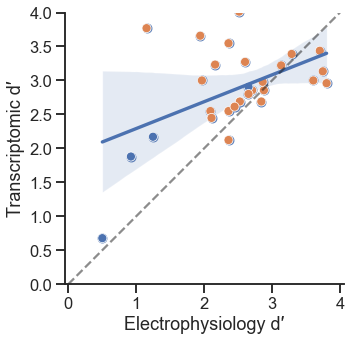

In [55]:
y = 'Transcriptomic d′'
x = 'Electrophysiology d′'
dflat = get_distances(ephys_dprime_rf, ps_dprime_zinb, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.plot([0,4],[0,4], 'k--', alpha=0.5)
plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

r=0.61, p=0.00063


(0.0, 4.0)

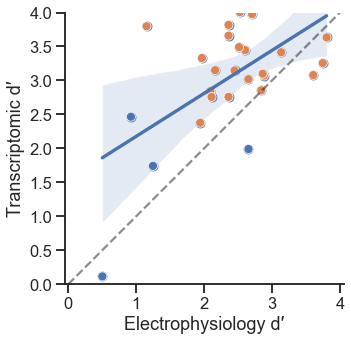

In [43]:
y = 'Transcriptomic d′'
x = 'Electrophysiology d′'
dflat = get_distances(ephys_dprime_rf, ps_dprime_zinb, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.plot([0,4],[0,4], 'k--', alpha=0.5)
plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

r=0.59, p=0.00096


(-0.2, 4.2, -0.25795926364731064, 5.417144536593524)

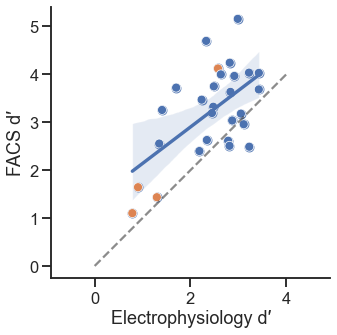

In [159]:
y = 'FACS d′'
x = 'Electrophysiology d′'
dflat = get_distances(ephys_dprime_rf, facs_dprime, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.plot([0,4],[0,4], 'k--', alpha=0.5)
plt.axis('equal')

r=0.57, p=5e-05


(-0.2339252789382306,
 4.912430857702843,
 -0.25795926364731064,
 5.417144536593524)

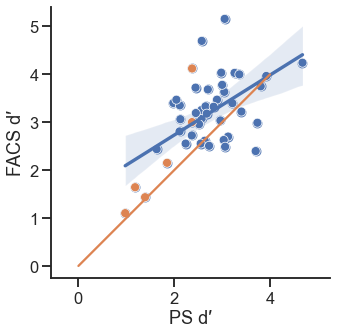

In [149]:
y = 'FACS d′'
x = 'PS d′'
dflat = get_distances(ps_dprime_zinb, facs_dprime, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.plot([0,4],[0,4])
plt.axis('equal')
# plt.xlim(0,4)
# plt.ylim(0,4)

In [132]:
dflat['x/y'] = dflat[x]/dflat[y]
dflat.sort_values('x/y', ascending=False).head()

Electrophysiology d′  Transcriptomic d′ pair_type  \
level_0    level_1                                                          
SST CHRNA4 LAMP5 DBP                3.426917           2.701996   between   
VIP PCDH20 PAX6 CDH12               3.111850           2.518767   between   
           ADARB2 MC4R              3.053031           2.679330   between   
LAMP5 NMBR LAMP5 LCP2               2.574366           2.373320    within   
LAMP5 LCP2 ADARB2 MC4R              3.222207           2.981468   between   

                             x/y  
level_0    level_1                
SST CHRNA4 LAMP5 DBP    1.268291  
VIP PCDH20 PAX6 CDH12   1.235466  
           ADARB2 MC4R  1.139476  
LAMP5 NMBR LAMP5 LCP2   1.084711  
LAMP5 LCP2 ADARB2 MC4R  1.080745

r=0.59, p=0.00098


(0.0, 4.0)

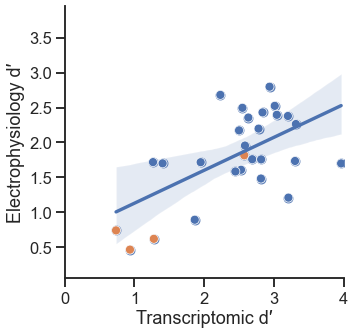

In [114]:
x = 'Transcriptomic d′'
y = 'Electrophysiology d′'
dflat = get_distances(ephys_dprime_rf, ps_dprime_sctgene, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)

plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

(0.0, 4.0)

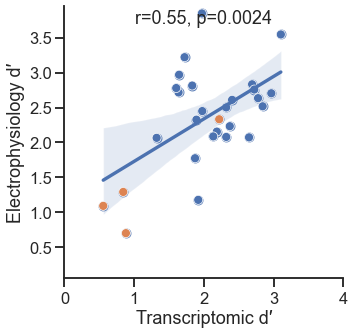

In [292]:
x = 'Transcriptomic d′'
y = 'Electrophysiology d′'
dflat = get_distances(ps_dprime, ephys_dprime_rf, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)

plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

(0.0, 4.0)

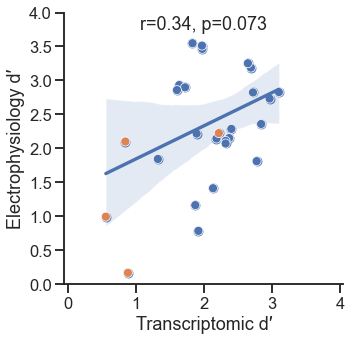

In [291]:
x = 'Transcriptomic d′'
y = 'Electrophysiology d′'
dflat = get_distances(ps_dprime, ephys_dprime_log, x, y)

fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, spearman=False, hue='pair_type', legend=False, ax=ax, smooth=True)

plt.axis('equal')
plt.xlim(0,4)
plt.ylim(0,4)

(0.5630139933038594, 3.457137209086984, 0.31884717760414205, 4.041995831501835)

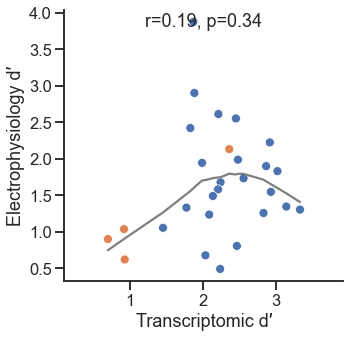

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True)
plt.axis('equal')

(0.0, 6.287403803903544)

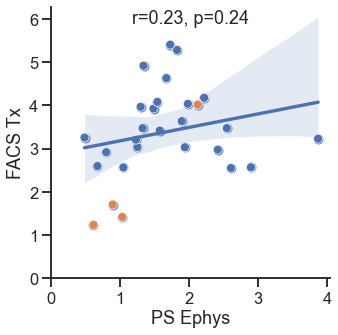

In [217]:
x = 'PS Ephys'
y = 'FACS Tx'
dflat = get_distances(ephys_dprime, facs_dprime, x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

In [37]:
dflat.loc[lambda df: df['PS Ephys'] > 2/3*df['FACS Tx']]

level_0      level_1  PS Ephys   FACS Tx pair_type
10  LAMP5 NMBR    LAMP5 DBP  1.033859  1.519298    within
56  VIP PCDH20   PAX6 CDH12  2.418032  3.038083   between
57  VIP PCDH20   LAMP5 NMBR  2.610221  2.622140   between
59  VIP PCDH20   LAMP5 LCP2  2.898564  2.631184   between
61  VIP PCDH20  ADARB2 MC4R  3.872762  3.325701   between

(0.0, 5.6144049628129284)

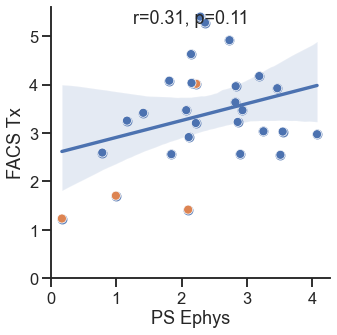

In [294]:
x = 'PS Ephys'
y = 'FACS Tx'
dflat = get_distances(ephys_dprime_log, facs_dprime, x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

(0.0, 5.830343608825847)

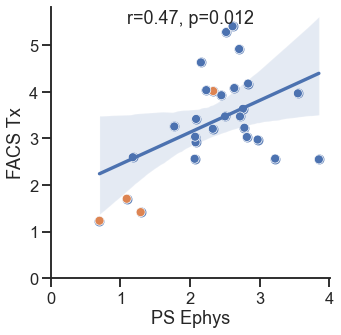

In [293]:
x = 'PS Ephys'
y = 'FACS Tx'
dflat = get_distances(ephys_dprime_rf, facs_dprime, x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

In [86]:
dflat.loc[lambda df: df['PS Ephys'] > 1.1*df['FACS Tx']]

level_0     level_1  PS Ephys   FACS Tx pair_type
57  VIP PCDH20  LAMP5 NMBR  3.712694  2.622140   between
59  VIP PCDH20  LAMP5 LCP2  3.434753  2.631184   between

In [250]:
from scipy.stats import spearmanr
import seaborn as sns

def dprime_similarity(df1, df2):
    cols = df1.columns.intersection(df2.columns)
    x1 = distance.squareform(df1.loc[cols, cols].values)
    x2 = distance.squareform(df2.loc[cols, cols].values)
    r, p = pearsonr(x1, x2)
    return r

def dprime_distplot(dprime_list, names, clusters=None):
    clusters = clusters or dprime_list[0].columns
    dist_vals = [distance.squareform(df.loc[clusters, clusters].values) for df in dprime_list]
    df = pd.DataFrame(dist_vals, index=names)
    all_dprimes = df.T.melt(var_name='dataset', value_name='dprime')

    # sns.displot(data=all_dprimes, x='dprime', hue='dataset', kind='kde')
    sns.violinplot(data=all_dprimes, x='dprime', y='dataset', cut=0)

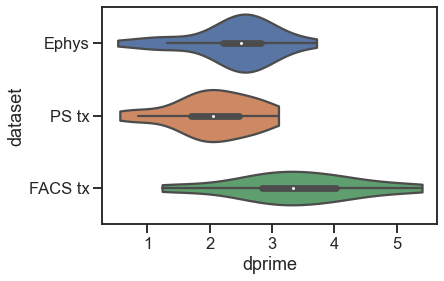

In [252]:
dprime_list = [ephys_dprime_rf, ps_dprime, facs_dprime, ]
names = ['Ephys', 'PS tx', 'FACS tx', ]
dprime_distplot(dprime_list, names)

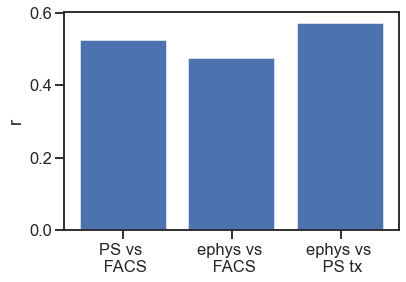

In [254]:
r1 = dprime_similarity(ps_dprime.loc[clusters, clusters], facs_dprime.loc[clusters, clusters])

r2 = dprime_similarity(ephys_dprime_rf, facs_dprime)

r3 = dprime_similarity(ps_dprime, ephys_dprime_rf)

plt.bar(range(3), [x for x in [r1, r2, r3]])
plt.ylabel('r')
plt.xticks(ticks=range(3), labels=['PS vs \n FACS', 'ephys vs \n FACS', 'ephys vs \n PS tx'])
plt.show()

## Ion channel gene set

In [94]:
gene_df = pd.read_csv('../data/ion_channel_gene_group.tsv', sep=None)
ion_genes = gene_df['Approved symbol'].tolist()
exclude = ['CATSPERE', 'CATSPERZ']
ion_genes = [x for x in ion_genes if x not in exclude]

shiny_dir = shiny.shiny_directory('human')
ps_ic_dprime = tx_dprime(shiny_dir, ion_genes, l1_types_human, zero_inflated=False)

shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
facs_ic_dprime = tx_dprime(shiny_dir, ion_genes, l1_types_human_ps, zero_inflated=False, 
                        nms_pass=False, type_col='cluster', translate_facs_names=True)

dprime_list = [ps_ic_dprime, facs_ic_dprime, ps_dprime, facs_dprime, ]
names = [ 'PS IC', 'FACS IC', 'PS tx', 'FACS tx', ]
dprime_distplot(dprime_list, names)

/tmp/ipykernel_6769/1901144640.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  gene_df = pd.read_csv('../data/ion_channel_gene_group.tsv', sep=None)


using data with shape (658, 328)
0
using data with shape (1136, 328)
0


/local1/storage/envs/ipfx38/lib/python3.8/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: Distance matrix 'X' must be symmetric.

using data with shape (658, 428)
0
using data with shape (1136, 428)
0


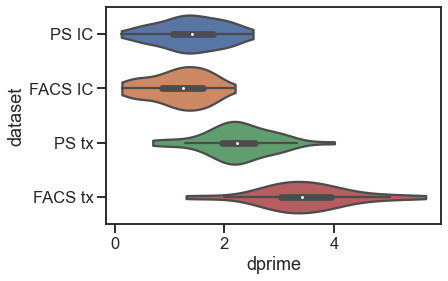

In [127]:
gene_df = pd.read_csv('../genes/ic_genes.txt', header=None)
ion_genes = gene_df[0].tolist()

shiny_dir = shiny.shiny_directory('human')
ps_ic_dprime = tx_dprime(shiny_dir, ion_genes, l1_types_human_ps, zero_inflated=False,
                          translate_ps_names=True)

shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
facs_ic_dprime = tx_dprime(shiny_dir, ion_genes, l1_types_human_facs, zero_inflated=False, 
                        nms_pass=False, type_col='cluster')

dprime_list = [ps_ic_dprime, facs_ic_dprime, ps_dprime, facs_dprime, ]
names = [ 'PS IC', 'FACS IC', 'PS tx', 'FACS tx', ]
dprime_distplot(dprime_list, names)

(0.0, 2.402342985155949)

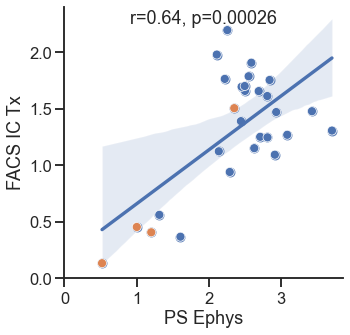

In [128]:
x = 'PS Ephys'
y = 'FACS IC Tx'
dflat = get_distances(ephys_dprime_rf, facs_ic_dprime.loc[clusters, clusters], x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

(0.0, 2.67025894485524)

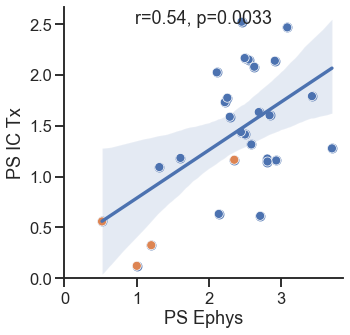

In [130]:
x = 'PS Ephys'
y = 'PS IC Tx'
dflat = get_distances(ephys_dprime_rf, ps_ic_dprime.loc[clusters, clusters], x, y)
fig, ax = plt.subplots(figsize=(5,5))
plot_corr(data=dflat, x=x, y=y, hue='pair_type', legend=False, ax=ax, smooth=True, spearman=False)
ax.set_xlim(0,None)
ax.set_ylim(0,None)

## subclass level species comparison

In [95]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', index_col=0)['Gene'].tolist()
shiny_dir = shiny.shiny_directory('human')
subclass_dict = {key:val for key, val in homology_mapping_human.items() if not 'other' in val}
ps_subclass_dprime = tx_dprime(shiny_dir, gene_list, l1_types_human, zero_inflated=False, 
                               shorten_names=True,
                               subclass_dict=subclass_dict)

using data with shape (575, 747)
0


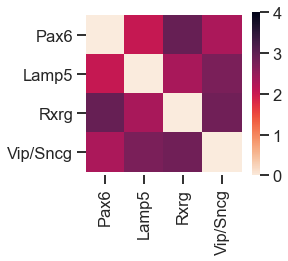

In [96]:
plt.figure(figsize=(3.5,3))
sns.heatmap(ps_subclass_dprime, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

In [97]:
gene_list = pd.read_csv('/home/tom.chartrand/work/mouse-met-figures/data/human_MTG_markers.csv', index_col=0)['Gene'].tolist()
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
subclass_dict = {key:val for key, val in homology_mapping_human.items() if not 'other' in val}
facs_subclass_dprime = tx_dprime(shiny_dir, gene_list, l1_types_human, zero_inflated=False, 
                            shorten_names=True,
                               subclass_dict=subclass_dict, 
                               nms_pass=False, type_col='cluster', translate_facs_names=True)

using data with shape (996, 747)
0


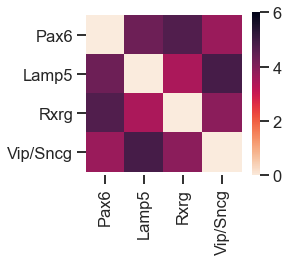

In [98]:
plt.figure(figsize=(3.5,3))
hom_order = ['Pax6','Lamp5','Rxrg','Vip/Sncg']
sns.heatmap(facs_subclass_dprime.loc[hom_order, hom_order], cmap='rocket_r', vmin=0, vmax=6, cbar=True)
plt.axis('equal')
plt.show()

In [99]:
shiny_dir = shiny.shiny_directory('mouse')
# shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/patch_seq/star/mouse_patchseq_VISp_20200318_collapsed40_cpm'
gene_list = pd.read_csv("/home/tom.chartrand/work/mouse-met-figures/data/select_markers.csv", index_col=0)['Gene'].tolist()
                      
l1_types_mouse = homology_mapping_mouse.keys()
ps_subclass_dprime_m = tx_dprime(shiny_dir, gene_list, l1_types_mouse, zero_inflated=False, shorten_names=False,
                               subclass_dict=homology_mapping_mouse)

using data with shape (1418, 4020)
0


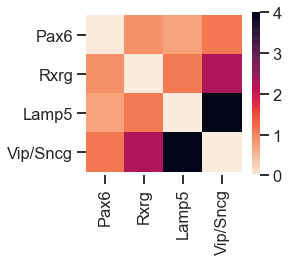

In [100]:
plt.figure(figsize=(3.5,3))
sns.heatmap(ps_subclass_dprime_m, cmap='rocket_r', vmin=0, vmax=4, cbar=True)
plt.axis('equal')
plt.show()

## Constellation diagram overlap

In [615]:

df = pd.read_csv("data/cluster_overlap_matrix.csv", index_col=0)
cl_df = pd.read_csv("/home/tom.chartrand/work/r_patchseq/constellation_trygve/cluster_anno.csv", index_col='name')

for cl in df.columns:
    for cl2 in df.columns:
        df.loc[cl, cl2] /= cl_df.loc[cl, 'size'] + cl_df.loc[cl2, 'size']

df.index = df.index.map(shorten_name)
df.columns = df.columns.map(shorten_name)
l1_types_short = [shorten_name(x) for x in l1_types_human]
df = df.loc[l1_types_short, l1_types_short]

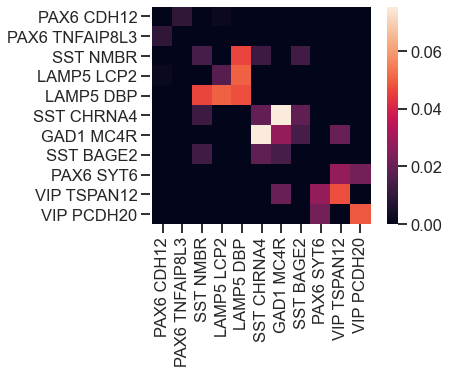

In [624]:
plt.figure(figsize=(5,4))
sns.heatmap(df)
plt.axis('equal')
plt.show()

In [627]:
coclust_d = 1 - df
np.fill_diagonal(coclust_d.values, 0)
dprime_similarity(facs_dprime, coclust_d)

SpearmanrResult(correlation=0.46585829184662103, pvalue=0.0003379547340892743)

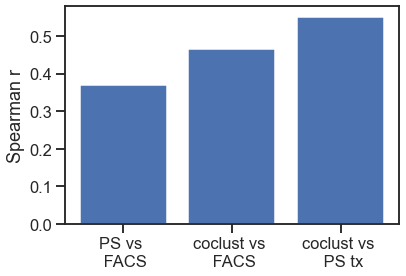

In [630]:
r1 = dprime_similarity(ps_dprime.loc[clusters, clusters], facs_dprime.loc[clusters, clusters])

r2 = dprime_similarity(coclust_d, facs_dprime)

r3 = dprime_similarity(ps_dprime, coclust_d)

plt.bar(range(3), [x.correlation for x in [r1, r2, r3]])
plt.ylabel('Spearman r')
plt.xticks(ticks=range(3), labels=['PS vs \n FACS', 'coclust vs \n FACS', 'coclust vs \n PS tx'])
plt.show()

## FV ephys dprime

[Text(0.5, 4.5, ''), Text(72.90000000000005, 0.5, '')]

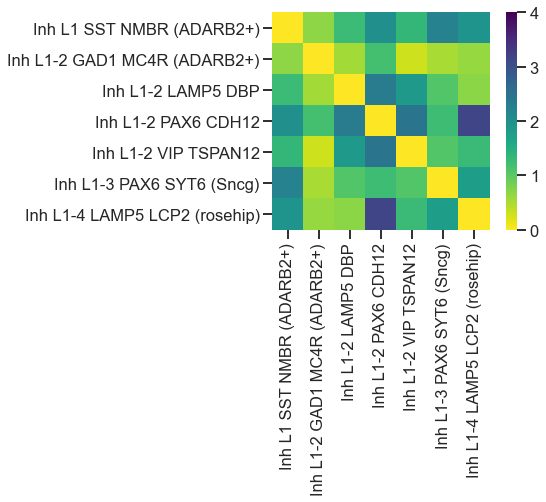

In [191]:
import json
    
ephys_dprime_file = "/home/tom.chartrand/work/mouse-met-figures/derived_data/ephys_all_dprime.json"
with open(ephys_dprime_file, "r") as f:
    data = json.load(f)
    
type_list = data["types"]
fig, ax = plt.subplots()
all_data = data["data"]

df = pd.DataFrame(0*np.eye(len(type_list)), index=type_list, columns=type_list)
for data in all_data.values():
    for d in data:
        val = max(d["dprime"], 0)
        val = val if np.isfinite(val) else 0
        df.loc[d["type1"], d["type2"]] = np.sqrt(val**2 + df.loc[d["type1"], d["type2"]]**2)
df = df + df.T
sns.heatmap(df, square=True,
    cmap="viridis_r",
    xticklabels=type_list,
    yticklabels=type_list,
    vmin=0, vmax=4, ax=ax)
ax.set(xlabel="", ylabel="")